In [1]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_models/NVspin_SimpleRNN_model.h5')

2023-09-14 16:04:25.298336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 16:04:26.202490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-14 16:04:27.283267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 16:04:27.326266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 16:04:27.326370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

In [2]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_theta, target_phi):
    
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @ target_U.conj().T

    new_theta = np.array(target_theta).reshape(-1, 1)
    new_phi = np.array(target_phi).reshape(-1, 1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [3]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     
     target_theta = np.pi / 180 * random.uniform(0,180)
     target_phi = np.pi / 180 * random.uniform(0,360)
     
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp

print(sum/iter)

1/1 [==============================] - 0s 25ms/step


2023-09-14 16:04:31.818930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 37ms/step
0.9899785560676715


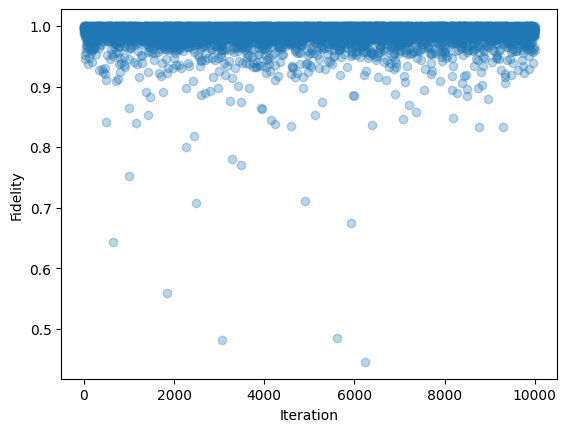

In [4]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [5]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

6 0.98626993586227
9 0.988488528223175
17 0.9450066556549814
19 0.9792384151329794
20 0.9837669913575761
29 0.9517207214986699
33 0.9884368721829577
34 0.9875609040701065
39 0.963108501429317
42 0.9680634006854909
49 0.9853319485880151
50 0.957424446495896
53 0.9898535869394415
54 0.989787007020277
59 0.9852419815115877
60 0.9826171829878282
62 0.9770620894354952
64 0.96625947876958
65 0.9884549076490246
67 0.9818896378978021
72 0.9730855366878367
73 0.9748942747397062
81 0.9897323769531478
85 0.9868516498405872
90 0.988630511347206
92 0.9818289142049463
93 0.9842408505740292
94 0.9805251096479365
95 0.9897810699080728
96 0.9845080894814103
97 0.970248950667885
101 0.936526678856844
102 0.9754872400884467
105 0.9833482199290836
106 0.9884154476983672
108 0.9631053559893568
114 0.9893743681839731
116 0.9473836622052308
117 0.9763788898490746
124 0.982102990989113
127 0.9877292792602897
128 0.9828402872981822
129 0.9862195558162046
130 0.9763816059930356
131 0.9826453918552069
132 0.9840

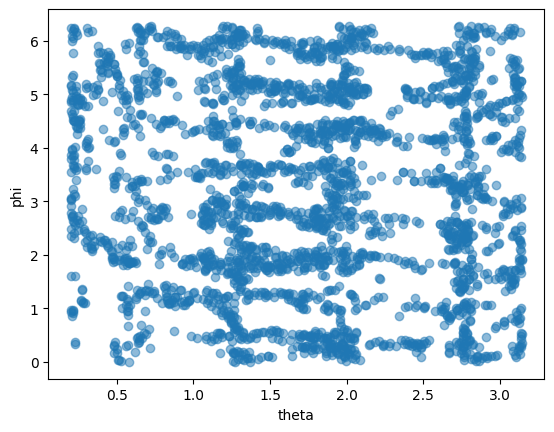

In [6]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

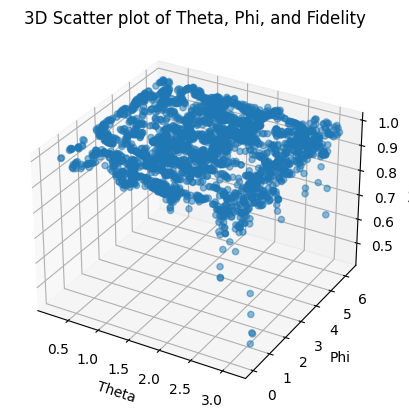

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()
